In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize
from skimage.color import rgb2gray
from skimage.transform import resize
%matplotlib inline
imagedir = '../img_data/Images'

In [52]:
def load_images(num_classes, h, w):
    
    # preinitialize the matrix
    #img_arr = np.empty((num_samples_per_breed*num_breeds,h*w))  # 20 instances of each breed, each img will be 200x200 = 40000 pixels
    img_arr = []
    label_arr = []
    
    # sample 60 breeds from the dataset
    a = np.arange(len(os.listdir(imagedir)))
    np.random.shuffle(a)
    breed_sample_idxs = a[:num_classes]
    for i, idx in enumerate(breed_sample_idxs):
        breed = os.listdir(imagedir)[idx]
        if breed[0] == '.' : 
            continue # stupid ds.store on mac
        print(i,breed)
        
        for img in os.listdir(os.path.join(imagedir, breed)):
            dog_path = os.path.join(imagedir,breed,img)            

            img = plt.imread(dog_path)
            
            # converts image to gray, resizes it to be 200x200, and then linearizes it
            img_gray_resize_flat = rgb2gray(resize(img, (h,w,3))).flatten()
                        
            img_arr.append(img_gray_resize_flat)

            # add name to list of labels
            fname = dog_path.split('/')[-1] # 'dog_name_123497.jpg'
            dog_name = fname[:fname.rfind('_')] # 'dog_name'
            label_arr.append(breed)
            
    return img_arr, label_arr

In [53]:
%%time
num_breeds = 5
h=128
w=128
dogs, labels = load_images(num_classes=num_breeds, h=h, w=w)
print(len(dogs))

0 Pomeranian


C:\Users\leima\AppData\Local\conda\conda\envs\my_root\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1 chow
2 toy_terrier
3 Eskimo_dog
4 Kerry_blue_terrier
916
Wall time: 18.5 s


In [54]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df= pd.DataFrame(dogs)

X = np.array(dogs)
enc = LabelEncoder()
y = enc.fit_transform(labels)

img_wh = 128


In [55]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.0.9'

In [56]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(0) # using this to help make results reproducible

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

(732, 16384)

In [57]:
NUM_CLASSES = 5
print(X_train.shape)
print(X_test.shape)

(732, 16384)
(184, 16384)


In [58]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=10, 
        shuffle=True, verbose=1)

Epoch 1/10
732/732 [==============================] - 1s 2ms/step - loss: 0.2913 - acc: 0.2473
Epoch 2/10
732/732 [==============================] - 1s 713us/step - loss: 0.2989 - acc: 0.2527
Epoch 3/10
732/732 [==============================] - 1s 710us/step - loss: 0.2989 - acc: 0.2527
Epoch 4/10
732/732 [==============================] - 1s 729us/step - loss: 0.2989 - acc: 0.2527
Epoch 5/10
732/732 [==============================] - 1s 744us/step - loss: 0.2972 - acc: 0.2473
Epoch 6/10
732/732 [==============================] - 0s 653us/step - loss: 0.2921 - acc: 0.2377
Epoch 7/10
732/732 [==============================] - 1s 712us/step - loss: 0.2416 - acc: 0.2650
Epoch 8/10
732/732 [==============================] - 0s 666us/step - loss: 0.2229 - acc: 0.2773
Epoch 9/10
732/732 [==============================] - 0s 677us/step - loss: 0.2209 - acc: 0.2842
Epoch 10/10
732/732 [==============================] - 1s 701us/step - loss: 0.2064 - acc: 0.3279
Wall time: 6.42 s


In [62]:
%%time

cnn_layers = [16, 16]

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,h,w), input_shape=(1,h*w)))

for n in cnn_layers:
    cnn.add(Conv2D(filters=n, kernel_size= (3, 3), padding='same', input_shape=(1,h,w),data_format="channels_first"))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(50))
cnn.add(Activation('relu'))
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))


# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=10, 
        shuffle=True, verbose=1)

Epoch 1/10
732/732 [==============================] - 31s 42ms/step - loss: 0.1596 - acc: 0.2473
Epoch 2/10
732/732 [==============================] - 29s 40ms/step - loss: 0.1468 - acc: 0.4180
Epoch 3/10
732/732 [==============================] - 31s 42ms/step - loss: 0.1329 - acc: 0.4973
Epoch 4/10
732/732 [==============================] - 30s 41ms/step - loss: 0.1207 - acc: 0.5615
Epoch 5/10
732/732 [==============================] - 31s 42ms/step - loss: 0.1099 - acc: 0.6025
Epoch 6/10
732/732 [==============================] - 29s 39ms/step - loss: 0.1013 - acc: 0.6585
Epoch 7/10
732/732 [==============================] - 29s 40ms/step - loss: 0.0920 - acc: 0.6858
Epoch 8/10
732/732 [==============================] - 29s 39ms/step - loss: 0.0805 - acc: 0.7309
Epoch 9/10
732/732 [==============================] - 28s 39ms/step - loss: 0.0722 - acc: 0.7678
Epoch 10/10
732/732 [==============================] - 29s 39ms/step - loss: 0.0621 - acc: 0.8156
Wall time: 4min 57s


In [63]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('MLP: '+str(acc_mlp))

C:\Users\leima\AppData\Local\conda\conda\envs\my_root\lib\site-packages\seaborn\matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
C:\Users\leima\AppData\Local\conda\conda\envs\my_root\lib\site-packages\seaborn\matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


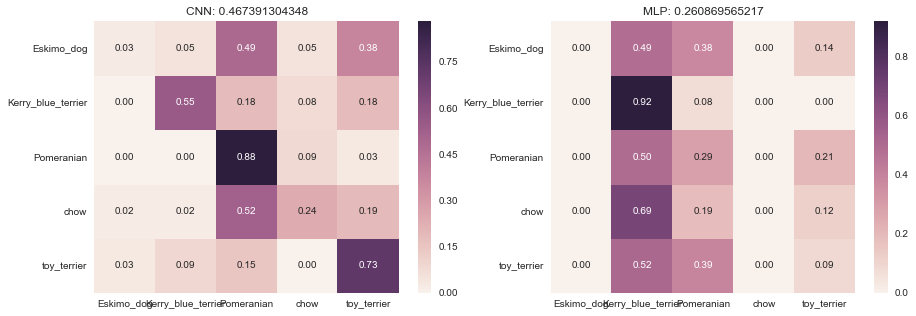

In [64]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

keras.__version__

'2.0.9'

In [84]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
import os
import struct
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    return '{:.4f}'.format(acc)



In [66]:
l2_lambda = 0.0001
img_hw = 128
X = np.expand_dims(X.reshape(-1,img_hw,img_hw), axis=3)
#X = np.expand_dims(X_train, axis=12)
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(X_train.shape)
print(y_train.shape)
print(y_test_ohe)

(732, 128, 128, 1)
(732,)
[[ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0

# Ensemble

In [80]:
%%time
#without datagen
from keras.layers import average 
from keras.models import Input, Model

num_ensembles = 3

input_holder = Input(shape=(img_wh, img_wh, 1))

branches = []
for _ in range(num_ensembles):

    conv1 = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu',data_format="channels_last")(input_holder)
    
    max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

    conv2 = Conv2D(filters=32,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu',data_format="channels_last")(max1)
    
    max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


    # add one layer on flattened output
    drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
    flat1 = Flatten()(drop1)
    dense1 = Dense(128, 
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(l2_lambda)
                )(flat1)
    drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
    dense2 = Dense(NUM_CLASSES, 
                  activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=l2(l2_lambda)
                 )(drop2)
    
    # now add this branch onto the master list
    branches.append(dense2)

# that's it, we just need to average the results
ave = average(branches)

# here is the secret sauce for setting the network using the 
#   Model API:
cnn_ens = Model(inputs=input_holder,outputs=ave)

# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=3, 
        shuffle=True, verbose=1)

Epoch 1/3
732/732 [==============================] - 65s 88ms/step - loss: 1.8808 - acc: 0.2063
Epoch 2/3
732/732 [==============================] - 65s 89ms/step - loss: 1.7825 - acc: 0.2131
Epoch 3/3
732/732 [==============================] - 57s 78ms/step - loss: 1.6788 - acc: 0.2486
Wall time: 3min 8s


In [89]:
from keras.layers import average 
from keras.models import Input, Model
def Ensemble(X_train, y_train_ohe, X_test, y_test):


    num_ensembles = 3

    input_holder = Input(shape=(img_wh, img_wh, 1))

    branches = []
    for _ in range(num_ensembles):

        conv1 = Conv2D(filters=32,
                       input_shape = (img_wh,img_wh,1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(input_holder)

        max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

        conv2 = Conv2D(filters=32,
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(max1)

        max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


        # add one layer on flattened output
        drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
        flat1 = Flatten()(drop1)
        dense1 = Dense(128, 
                      activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_lambda)
                    )(flat1)
        drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
        dense2 = Dense(NUM_CLASSES, 
                      activation='sigmoid', 
                      kernel_initializer='glorot_uniform',
                      kernel_regularizer=l2(l2_lambda)
                     )(drop2)

        # now add this branch onto the master list
        branches.append(dense2)

    # that's it, we just need to average the results
    ave = average(branches)

    # here is the secret sauce for setting the network using the 
    #   Model API:
    cnn_ens = Model(inputs=input_holder,outputs=ave)

    # Let's train the model 
    cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='rmsprop', # 'adadelta' 'rmsprop'
                    metrics=['accuracy'])

    # the flow method yields batches of images indefinitely, with the given transofmrations
    cnn_ens.fit(X_train, y_train_ohe, 
            batch_size=32, epochs=3, 
            shuffle=True, verbose=1)
    accuracy = summarize_net(cnn_ens, X_test, y_test, title_text='CNN Ensemble:')
    yhat = np.argmax(cnn_ens.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    return '{:.4f}'.format(acc)

In [90]:
 Ensemble(X_train, y_train_ohe, X_test, y_test)

Epoch 1/3
 64/732 [=>............................] - ETA: 1:31 - loss: 2.4704 - acc: 0.1562

KeyboardInterrupt: 

In [37]:
print(X_test.shape)
print(y_test_ohe.shape)

(181, 128, 128, 1)
(181, 5)


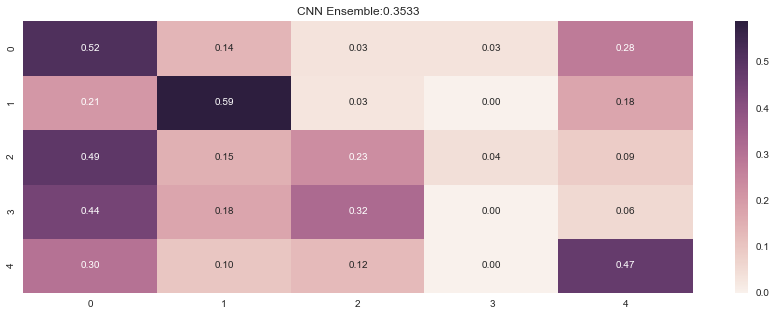

In [85]:
accuracy = summarize_net(cnn_ens, X_test, y_test, title_text='CNN Ensemble:')


In [87]:
print(accuracy)

0.3533


In [77]:
%%time

from keras.layers import average 
from keras.models import Input, Model

num_ensembles = 3

input_holder = Input(shape=(img_wh, img_wh, 1))

branches = []
for _ in range(num_ensembles):

    conv1 = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_first")(input_holder)
    
    max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(conv1)

    conv2 = Conv2D(filters=32,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_first")(max1)
    
    max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(conv2)


    # add one layer on flattened output
    drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
    flat1 = Flatten()(drop1)
    dense1 = Dense(128, 
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(l2_lambda)
                )(flat1)
    drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
    dense2 = Dense(NUM_CLASSES, 
                  activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=l2(l2_lambda)
                 )(drop2)
    
    # now add this branch onto the master list
    branches.append(dense2)

# that's it, we just need to average the results
ave = average(branches)

# here is the secret sauce for setting the network using the 
#   Model API:
cnn_ens = Model(inputs=input_holder,outputs=ave)

# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=10, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_111/MaxPool' (op: 'MaxPool') with input shapes: [?,128,1,32].

ValueError: Error when checking : expected input_2 to have 4 dimensions, but got array with shape (162, 1, 16384)

In [ ]:
print(X_train.shape)
print(y_train_ohe.shape)
print(X_test.shape)
print(y_test_ohe.shape)

# Simple

In [82]:
%%time 

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

cnn = Sequential()

cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit(X_train, y_train_ohe, batch_size=128, 
                    # how many generators to go through per epoch
                   epochs=10, verbose=1,
                   shuffle=True
                  )


Epoch 1/10
732/732 [==============================] - 90s 123ms/step - loss: 4.6753 - acc: 0.1872
Epoch 2/10
732/732 [==============================] - 88s 120ms/step - loss: 1.5747 - acc: 0.2964
Epoch 3/10
732/732 [==============================] - 83s 113ms/step - loss: 1.4805 - acc: 0.4085
Epoch 4/10
732/732 [==============================] - 85s 116ms/step - loss: 1.3253 - acc: 0.4467
Epoch 5/10
732/732 [==============================] - 104s 143ms/step - loss: 1.2134 - acc: 0.5178
Epoch 6/10
732/732 [==============================] - 93s 127ms/step - loss: 1.1347 - acc: 0.5820
Epoch 7/10
732/732 [==============================] - 90s 123ms/step - loss: 1.0175 - acc: 0.6270
Epoch 8/10
732/732 [==============================] - 90s 124ms/step - loss: 0.8461 - acc: 0.7117
Epoch 9/10
732/732 [==============================] - 95s 130ms/step - loss: 0.7018 - acc: 0.7760
Epoch 10/10
732/732 [==============================] - 92s 125ms/step - loss: 0.5133 - acc: 0.8511
Wall time: 15min 9

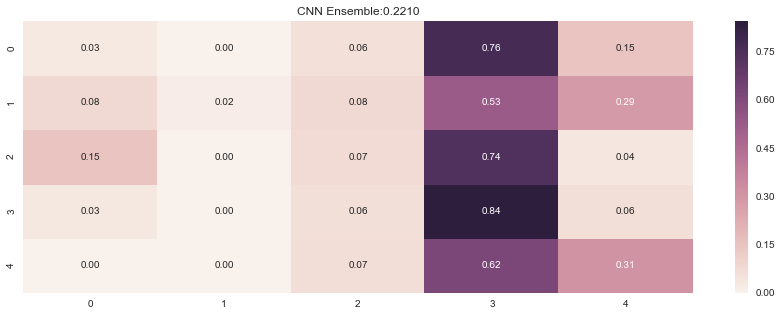

In [46]:
summarize_net(cnn, X_test, y_test, title_text='CNN Ensemble:')